# 5-Trip Endpoints

In this notebook we calculate the areas where the trips most commonly start and end. We call these the _trip endpoints_. Usually you also find these named as "_stay points_" in the literature but, due to the nature of the data that we are handling, where vehicles do not stop at these locations, we will keep the name "_endpoint_".

**Requirements:**

- Please run the `2-import-data.ipynb` notebook first, in case you need to buid the supporting SQLite database.
- Recommended install: [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html). Enable using `jupyter nbextension enable --py widgetsnbextension --sys-prefix` for Jupyter Notebook and `jupyter labextension install @jupyter-widgets/jupyterlab-manager` for Jupyter Lab.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import folium

from sqlapi import VedDb
from h3 import h3
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from folium.vector_layers import CircleMarker
from colour import Color

%matplotlib inline

Let's start by instantiating the `VedDb` object to interface with the SQLite database created and prepared in previous notebooks.

In [2]:
db = VedDb()

Now, we collect the start and end locations of all the moves in the database as latitude and longitude pairs. Note that we have to join the `move` table to the `signal` table twice in order to get both start and end loctions. The result is downloaded into a DataFrame for in-memory manipulation.

In [3]:
sql = """
select     m.move_id
,          m.vehicle_id
,          m.day_num
,          m.ts_ini                 -- Start timestamp
,          m.ts_end                 -- Destination timestamp
,          si.latitude  as lat_ini  -- Start point latitude
,          si.longitude as lon_ini  -- Start point longitude
,          se.latitude  as lat_end  -- Destination location latitude
,          se.longitude as lon_end  -- Destination location longitude
from       move m
inner join signal si on si.day_num = m.day_num and si.vehicle_id = m.vehicle_id and si.time_stamp = m.ts_ini
inner join signal se on se.day_num = m.day_num and se.vehicle_id = m.vehicle_id and se.time_stamp = m.ts_end
"""
df_pt = db.query_df(sql)
df_pt.head()

,move_id,vehicle_id,day_num,ts_ini,ts_end,lat_ini,lon_ini,lat_end,lon_end
0,1,2,9.558109,0,168000,42.302569,-83.704196,42.298003,-83.720282
1,2,2,11.594001,0,445400,42.316064,-83.734245,42.286760,-83.732760
2,3,2,17.718441,0,335100,42.287684,-83.733198,42.295392,-83.705040
3,4,2,34.700724,0,669900,42.242183,-83.767351,42.309024,-83.678324
4,5,2,50.936015,0,283900,42.304893,-83.692733,42.302671,-83.703831


As you can see, for each move we collect the start location `(lat_ini, lon_ini)` and destination location `(lat_end, lon_end)`. Using this data, we can determine the implied geographical clusters using DBSCAN. Before running that algorithm, we must first collect all locations into a single array, keeping the original ordering. The first half of the array contains the start locations while the second part contains the end locations. This is important in order to guarantee that we can assign the detetcted cluster identifiers back to the `move` table.

In [4]:
loc_ini = df_pt[['lat_ini', 'lon_ini']].to_numpy()
loc_end = df_pt[['lat_end', 'lon_end']].to_numpy()
locations = np.vstack((loc_ini, loc_end))

Before running the first phase of the clustering process, we must estimate the value for $\epsilon$, the maximum distance between points. Here, we follow the methodology described here: [DBSCAN Python Example: The Optimal Value For Epsilon (EPS)](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc). 

In [5]:
nn = NearestNeighbors(n_neighbors=2,
                      metric='haversine',
                      algorithm='ball_tree',
                      n_jobs=-1)
pts = np.radians(locations)
nbrs = nn.fit(pts)
distances, indices = nbrs.kneighbors(pts)

Now, we plot the sorted distances and look for the approximate location of the curve's elbow.

(0.0, 50.0)

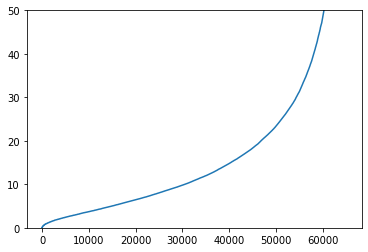

In [6]:
dist = np.sort(distances, axis=0)
dist = dist * 40070000.0
plt.plot(dist[:, 1])
plt.ylim((0, 50))

Looking at the above chart, we can would _postulate_ $ \epsilon $ = 25.

Now that we have all the locations ready we can cluster them using DBSCAN. The following function (`cluster_locations`) does just that. It assumes that clusters are valid when you can collect at least ten vehicles with distances of at most 25 meters in between.

In [7]:
def calculate_clusters(locations, eps_in_meters=25.0, num_samples=20):
    pts = np.radians(locations)

    # Cluster the data
    earth_perimeter = 40070000.0  # In meters
    eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

    clusters = DBSCAN(eps=eps_in_radians, 
                      min_samples=num_samples,
                      metric='haversine',
                      algorithm='ball_tree').fit_predict(pts)
    return clusters

Now, we run the code against the location array and collect the cluster identifiers in the same order as that of the inputs.

In [8]:
clusters = calculate_clusters(locations)

The list of unique cluster identifiers is calculated below by removing the first unique value (-1), the noise indicator.

In [9]:
unique_clusters = np.unique(clusters)[1:]
print("The initial number of clusters is: {0}".format(unique_clusters.shape[0]))

The initial number of clusters is: 253


## Cluster Quality Inspection

Now we can have a quick look at the quality of the geenerated clusters by plotting their calculated locations. As we will see, some of the clusters are too large and can (and should) split further.

Note: The code below starts at cluster number 17 to demonstrate the point of a cluster that should be futher split.

In [10]:
cluster_id = 17

Create the folium map.

In [11]:
tiles = "cartodbpositron"
map = folium.Map(prefer_canvas=True)
t = folium.TileLayer(tiles).add_to(map)

Extract the cluster coordinates.

In [12]:
cluster_points = locations[clusters == cluster_id]

Plot each location on the map as a blue dot.

In [13]:
for point in cluster_points:
    CircleMarker(point, radius=1).add_to(map)

Fit the map to the set of locations and display it.

In [14]:
min_lat, max_lat = cluster_points[:, 0].min(), cluster_points[:, 0].max()
min_lon, max_lon = cluster_points[:, 1].min(), cluster_points[:, 1].max()
map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
map

You can further explore the quality of the generated clusters by changing the `cluster_id` variable and re-running the above code.

## Cluster Refinement

We can now refine the existing clusters by running the same clustering algorithm on each cluster, but with different parameters. Let us first illustrate how to go about this using the selected cluster. We start by selecting the cluster locations:

In [15]:
cluster_points = locations[clusters==cluster_id]

Call the `cluster_locations` to further refine the cluster.

In [16]:
sub_cluster_ids = calculate_clusters(cluster_points, eps_in_meters=12.5, num_samples=15)
sub_clusters = np.unique(sub_cluster_ids[sub_cluster_ids >= 0])

In [17]:
print("There are {0} sub clusters.".format(sub_clusters.shape[0]))

There are 3 sub clusters.


Define a utility function to plot the clusters on a map.

In [18]:
def plot_cluster_points(clusters, locations, colors):
    tiles = "cartodbpositron"
    map = folium.Map(prefer_canvas=True)
    t = folium.TileLayer(tiles).add_to(map)
    
    for cluster in np.unique(clusters):
        for point in locations[clusters == cluster]:
            CircleMarker(point, radius=1, 
                         color=colors[cluster].hex if cluster >= 0 else "gray",
                         tooltip="{0}".format(cluster)).add_to(map)
    
    min_lat, max_lat = locations[:, 0].min(), locations[:, 0].max()
    min_lon, max_lon = locations[:, 1].min(), locations[:, 1].max()
    map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return map

In [19]:
colors=list(Color("red").range_to("green", len(sub_clusters)))

In [20]:
plot_cluster_points(sub_cluster_ids, cluster_points, colors=colors)

As you can see, there are a number of points that were classified as noise. We can try to _recover_ them back to the clusters by assigning them using a KNN-based approach. The function below, `reassign_noise_points`, does just that by returning the `indices` array of the `NearestNeighbors` call. These indices are then used to reassign the noise points to the nearest cluster, if possible.

In [21]:
def reassign_noise_points(cluster_ids, cluster_pts, k=7):
    nn = NearestNeighbors(n_neighbors=k,
                      metric='haversine',
                      algorithm='ball_tree',
                      n_jobs=-1)
    pts = np.radians(cluster_pts)
    nbrs = nn.fit(pts)
    distances, indices = nbrs.kneighbors(pts)
    return indices

We now call the `reassign_noise_points` function to get the indices back so we can work the reassignment.

In [22]:
indices = reassign_noise_points(sub_cluster_ids, cluster_points, k=7)

Now we loop through the _k-1_ nearest neighbor indices and sequentially assign the cluster identifier to the points that are still classified aas noise. Note that not all the noise points may be reassigned. You can try to increase the value of _k_ to assign more noise points to the clusters, but this will take more time to run.

In [23]:
for i in range(1, 7):
    sub_cluster_ids[indices[sub_cluster_ids == -1, 0]] = sub_cluster_ids[indices[sub_cluster_ids == -1, i]]

Let's see how the map looks like now.

In [24]:
plot_cluster_points(sub_cluster_ids, cluster_points, colors=colors)

## Automating the Process

After illustrating the process, we are now goingo to automate it throughout the clustered dataset.

In [25]:
max_cluster_id = unique_clusters.max()
for cluster_id in unique_clusters:
    cluster_points = locations[clusters==cluster_id]
    
    sub_cluster_ids = calculate_clusters(cluster_points, eps_in_meters=12.5, num_samples=5)
    sub_clusters = np.unique(sub_cluster_ids[sub_cluster_ids >= 0])
    
    if sub_clusters.shape[0] > 1:
        print("Cluster {0} has {1} sub clusters and {2} noise points".format(cluster_id, 
                                                                             sub_clusters.shape[0], 
                                                                             sub_cluster_ids[sub_cluster_ids == -1].shape[0]))
        indices = reassign_noise_points(sub_cluster_ids, cluster_points, k=7)
        for i in range(1, 7):
            sub_cluster_ids[indices[sub_cluster_ids == -1, 0]] = sub_cluster_ids[indices[sub_cluster_ids == -1, i]]
        
        sub_cluster_ids[sub_cluster_ids==0] = cluster_id
        for c in range(1, np.unique(sub_cluster_ids).shape[0]):
            max_cluster_id += 1
            sub_cluster_ids[sub_cluster_ids==c] = max_cluster_id
        clusters[clusters == cluster_id] = sub_cluster_ids

Cluster 6 has 2 sub clusters and 6 noise points
Cluster 12 has 3 sub clusters and 13 noise points
Cluster 16 has 2 sub clusters and 8 noise points
Cluster 17 has 2 sub clusters and 9 noise points
Cluster 19 has 2 sub clusters and 6 noise points
Cluster 24 has 2 sub clusters and 11 noise points
Cluster 26 has 4 sub clusters and 43 noise points
Cluster 30 has 2 sub clusters and 7 noise points
Cluster 34 has 2 sub clusters and 11 noise points
Cluster 35 has 2 sub clusters and 11 noise points
Cluster 44 has 2 sub clusters and 11 noise points
Cluster 45 has 2 sub clusters and 9 noise points
Cluster 49 has 2 sub clusters and 18 noise points
Cluster 52 has 3 sub clusters and 10 noise points
Cluster 54 has 2 sub clusters and 16 noise points
Cluster 62 has 2 sub clusters and 2 noise points
Cluster 63 has 2 sub clusters and 4 noise points
Cluster 69 has 2 sub clusters and 12 noise points
Cluster 75 has 2 sub clusters and 5 noise points
Cluster 88 has 2 sub clusters and 17 noise points
Cluster 10

In [26]:
print("The final number of clusters is: {0}".format(np.unique(clusters).shape[0]))

The final number of clusters is: 313


## Serialize to the Database

For the sake of future convenience, we will now create and fill in a table whith all the cluster points. This table will make our life much easier in the future, when handling clusters, their locations and shapes.

We start by making sure that the table exists and is empty.

In [27]:
if not db.table_exists("cluster_point"):
    sql = """
    CREATE TABLE cluster_point (
        pt_id           INTEGER PRIMARY KEY ASC,
        cluster_id      INT NOT NULL,
        latitude        FLOAT NOT NULL,
        longitude       FLOAT NOT NULL,
        h3              TEXT
    )
    """
    db.execute_sql(sql)
    db.execute_sql("CREATE INDEX idx_cluster_point_cluster ON cluster_point (cluster_id)")
else:
    db.execute_sql("DELETE FROM cluster_point")

Now, we can insert the locations for each cluster, along with the [H3](https://eng.uber.com/h3/) hexagon codes at [resolution level 12](https://uber.github.io/h3/#/documentation/core-library/resolution-table). In the next notebook, we will display the clusters using the outline of the collated shapes of all cluster hexagons.

To prepare the insert statement, we now collect all the input data into a list:

In [28]:
h3_level = 12
cluster_points = []
for i in tqdm(range(clusters.shape[0])):
    if clusters[i] >= 0:
        pt = (int(clusters[i]), locations[i, 0], locations[i, 1], h3.geo_to_h3(locations[i, 0], locations[i, 1], h3_level))
        cluster_points.append(pt)

We can now insert the cluster points into the table.

In [29]:
db.insert_cluster_points(cluster_points)

The DataFrame can also be updated with the cluster identifiers like so:

In [30]:
n = clusters.shape[0] // 2
df_pt['cluster_ini'] = clusters[:n]
df_pt['cluster_end'] = clusters[n:]

This is how the DataFrame looks like after cluster identifier assignment. Note that the constant `-1` means that the point was not assigned to any cluster, and was considered as noise instead. We will exclude these from the future trajectory analyses.

In [31]:
df_pt.head()

,move_id,vehicle_id,day_num,ts_ini,ts_end,lat_ini,lon_ini,lat_end,lon_end,cluster_ini,cluster_end
0,1,2,9.558109,0,168000,42.302569,-83.704196,42.298003,-83.720282,0,60
1,2,2,11.594001,0,445400,42.316064,-83.734245,42.286760,-83.732760,1,6
2,3,2,17.718441,0,335100,42.287684,-83.733198,42.295392,-83.705040,2,43
3,4,2,34.700724,0,669900,42.242183,-83.767351,42.309024,-83.678324,3,5
4,5,2,50.936015,0,283900,42.304893,-83.692733,42.302671,-83.703831,4,0


## Modifying the `move` Table

Now that we have the clusters identified, we can assign them back to the `move` table. Unfortunately, this table has no columns where to store the clusters identifiers, so we must first handle that. For convenience, we also create an extra index on the new columns for more convenient search on them.

**Notes**: 
- The function `table_has_column` tests whether a given table has a named column. Here we only test against one column as it is enough.
- Depending on the time you use this code, the database may already have been created with these columns and indexes. If that is the case, the code below does nothing.

In [32]:
if not db.table_has_column('move', 'cluster_ini'):
    db.execute_sql("alter table move add cluster_ini INT not null default -1")
    db.execute_sql("alter table move add cluster_end INT not null default -1")
    db.execute_sql("create index idx_move_clusters on move (cluster_ini, cluster_end)")

We are now ready to update the `move` table using the recently calculated cluster identifiers. To do so, we use the data stored in the DataFrame to feed an update query. Note that we retrieve the data as a list of tuples with the eaxct order for consumption in the query.

In [33]:
clids = list(df_pt[['cluster_ini', 'cluster_end', 'move_id']].itertuples(index=False))

In [34]:
db.update_move_clusters(clids)

We have now associated each move with a pair of endpoint clusters, and this allows us to perform more powerful analyses to the data, such as determine how many trips occur between two general endpoints, how many different trajectories there are and what vehicles have used them and at what time, consuming how much fuel or energy.

Now, we turn to the issue of generating a geo-fence for the clusters so they can be easily displayed on a map.